In [ ]:
#importing libraries
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [77]:
# URL raw dari file Excel di GitHub
url = 'https://raw.githubusercontent.com/robbyrmadhan/Indonesia-DirtyVote-Sentiment/main/Dataset/scrapingDV.xlsx'

# Membaca file Excel langsung dari URL
df = pd.read_excel(url, engine='openpyxl')

#### **FIRST INSPECTION**

In [ ]:
print(f'shape of df: {df.shape}')

In [78]:
#drop unneccessary columns
df.drop(columns= ['Unnamed: 0', 'published_at', 'updated_at'], inplace= True)

# rename column
df.rename(columns = {'text' : 'tweet'}, inplace= True)

df = df.sample(5000)

# check the result of first inspection
df.head()

,author,like_count,tweet
782,@abilamaherin7217,0,Gk ada tu nilai tambah dari film ini
1625,@agussusanto-do3tu,1,"Film ini adalah sumber kebencian, yg memihak salah satu paslon.... kebencian kebencian inilah yang akan membawa petaka untuk bangsa indonesia ini..karena yg terlibat dlm pembuatan film ini, se olah olah faham benar tentang hasil pilpres ... bhkan bisa menimbulkan fitnah...."
14337,@julehanurrohman9414,3,Beneran gw pusing bgt Yaa Allah 😢😢😢😢
1361,@arloaufa3208,0,"semoga dosa jariyah yg di peroleh dari video ini masij bisa di ampuni, walaupun hanya 11% 😢"
11325,@DanuWidodoo,1,dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote


#### **TEXT CLEANSING**

##### **One Step Function Version**

In [79]:
import re
import string
from nltk.tokenize import word_tokenize

def preprocess_text(df, column_name='tweet', new_column='clean_text'):
    # List regex patterns
    list_regex = [
        r'RT',  # remove RT
        r'<br\s*/?>',  # remove <br> tag
        r'<a\b[^>]*>(.*?)<\/a>',  # remove anchor tag
        r'\@[\w]+',  # remove mentions
        r'\#([\w]+)',  # remove hashtags
        r'[^\w\s]',  # remove punctuation
        r'\d+',  # remove numbers
        r'\n',  # remove newline
        r'\b\w{1,3}\b',  # remove short words
        r'[!$%^&*@#()_+|~=`{}\[\]%\-:";\'<>?,.\/]',  # remove special characters
        r'https?://\S+|www\.\S+',  # remove URL
        r"pic.twitter.com\S+",  # remove pic.twitter.com
        r'\s+',  # remove leading/trailing whitespaces and multiple spaces
        r'[^\x00-\x7F]+'  # remove non-ASCII characters
    ]

    # Convert text to lowercase
    df[new_column] = df[column_name].str.lower()
    
    # Apply multiple patterns
    for regex in list_regex:
        df[new_column] = df[new_column].apply(lambda tweet: re.sub(regex, ' ', tweet))
    
    # Remove tab, new line, and back slice
    df[new_column] = df[new_column].apply(lambda x: x.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',""))

    # NLTK word tokenize
    df['tokenized_text'] = df[new_column].apply(word_tokenize)
    
    return df

df = preprocess_text(df)

In [80]:
def cek_tweet_dengan_regex(df, pola_regex, kolom='tweet', jumlah_sampel=5, tampilkan_semua_kolom=False):
    # Menghitung jumlah tweet yang mengandung pola regex
    jumlah_tweet = df[kolom].str.contains(pola_regex, regex=True).sum()
    
    # Menentukan jumlah sampel yang akan diambil
    jumlah_sampel = min(jumlah_sampel, jumlah_tweet)
    
    # Mengambil sampel tweet yang mengandung pola regex
    if tampilkan_semua_kolom:
        sampel_tweet = df[df[kolom].str.contains(pola_regex, regex=True)].sample(jumlah_sampel)
    else:
        sampel_tweet = df.loc[df[kolom].str.contains(pola_regex, regex=True), [kolom]].sample(jumlah_sampel)
    
    # Menampilkan hasil
    print("Jumlah tweet yang mengandung '{}': {}".format(pola_regex, jumlah_tweet))
    
    return sampel_tweet

In [81]:
def check_tweet_with_specific_word(df, word, kolom='tweet', jumlah_sampel=5, tampilkan_semua_kolom=False):
    # Membuat pattern regex untuk mencari kata
    pattern = r'\b' + re.escape(word) + r'\b'
    
    # Mencari baris yang mengandung kata spesifik
    mask = df[kolom].str.contains(pattern, case=False, regex=True)
    
    # Mengambil baris yang sesuai
    hasil = df[mask]
    
    # Jika tidak ada hasil yang ditemukan
    if hasil.empty:
        print(f"Tidak ada tweet yang mengandung kata '{word}'.")
        return None
    
    # Mengambil sampel jika jumlah hasil lebih dari jumlah_sampel
    if len(hasil) > jumlah_sampel:
        hasil = hasil.sample(n=jumlah_sampel, random_state=42)
    
    # Menampilkan hasil
    if tampilkan_semua_kolom:
        hasil
    else:
        hasil[[kolom]]
    
    print(f"\nTotal tweet yang mengandung kata '{word}': {mask.sum()}")
    
    return hasil

In [123]:
def read_data(url, file_format='xlsx', sep=None):
    if file_format == 'xlsx':
        df = pd.read_excel(url, engine='openpyxl')
    elif file_format == 'json':
        df = pd.read_json(url)
    elif file_format in ['csv', 'txt']:
        df = pd.read_csv(url, delimiter=sep)
    else:
        raise ValueError("File format is not supported. Please use 'xlsx', 'csv', 'json', or 'txt'.")
    
    return df


In [93]:
def add_new_entries(dictionary, new_entries, key_column='slang', value_column='formal'):
    """
    Menambahkan entri baru ke dalam kamus (DataFrame atau dict) secara langsung,
    mengabaikan entri duplikat, dan mengembalikan panjang kamus sebelum dan setelah diupdate.
    
    :param dictionary: DataFrame atau dict yang berisi kamus (akan dimodifikasi langsung)
    :param new_entries: Dictionary dengan entri baru yang akan ditambahkan
    :param key_column: Nama kolom untuk kunci jika menggunakan DataFrame (default: 'slang')
    :param value_column: Nama kolom untuk nilai jika menggunakan DataFrame (default: 'formal')
    :return: Tuple (panjang_sebelum, panjang_setelah)
    """
    length_before = len(dictionary)

    if isinstance(dictionary, pd.DataFrame):
        for key, value in new_entries.items():
            if key not in dictionary[key_column].values:
                new_row = pd.DataFrame({key_column: [key], value_column: [value]})
                dictionary.loc[len(dictionary)] = new_row.iloc[0]
    elif isinstance(dictionary, dict):
        dictionary.update({k: v for k, v in new_entries.items() if k not in dictionary})
    else:
        raise ValueError("Input dictionary harus berupa pandas DataFrame atau dict Python.")
    
    # Drop duplicates
    dictionary.drop_duplicates(subset=key_column, keep='first', inplace=True)
    length_after = len(dictionary)
    
    return length_before, length_after

##### **Multiple Step Version**

###### **Handling RT (opsional)**

In [ ]:
cek_tweet_dengan_regex(df, r'\bRT\b', kolom= 'clean_text', jumlah_sampel=5)

###### **Handling HTML Tag**

In [ ]:
cek_tweet_dengan_regex(df, r'<br\s*/?>', jumlah_sampel=5)

In [ ]:
def remove_html_tag(df, column_name, new_column, jumlah_sampel=5):
    # Create a new column with HTML tags removed
    df[new_column] = df[column_name].apply(lambda tweet: re.sub(r'<br\s*/?>', ' ', tweet))
    
    # Print before and after removing HTML tag
    print("Before and after removing HTML tag:")
    output = df.loc[df[column_name] != df[new_column], [column_name, new_column]].sample(jumlah_sampel)

    return output

In [ ]:
remove_html_tag(df, 'tweet', 'html_tag_removed', jumlah_sampel= 2)

###### **Handling Anchor Tag**

In [ ]:
cek_tweet_dengan_regex(df, r'<a\b[^>]*>(.*?)<\/a>', jumlah_sampel=5)

In [ ]:
def remove_anchor_tag(df, column_name, new_column, jumlah_sampel=5):
    # Create a new column with HTML tags removed
    df[new_column] = df[column_name].apply(lambda tweet: re.sub(r'<a\b[^>]*>(.*?)<\/a>', ' ', tweet))
    
    # Print before and after removing HTML tag
    print("Before and after removing HTML tag:")
    output = df.loc[df[column_name] != df[new_column], [column_name, new_column]].sample(jumlah_sampel)

    return output

remove_anchor_tag(df, 'html_tag_removed', 'anchor_tag_removed', jumlah_sampel= 2)

###### **Handling Mention**

In [ ]:
cek_tweet_dengan_regex(df, r'\@[\w]+', jumlah_sampel=5)

In [ ]:
# Define function to remove mentions

def remove_mentions(df, column_name, new_column, jumlah_sampel=5):
    # Create a new column with mentions removed
    df[new_column] = df[column_name].apply(lambda tweet: re.sub(r'\@[\w]+', ' ', tweet))
    
    # Print before and after removing mentions
    print("Before and after removing mentions:")
    output = df.loc[df[column_name] != df[new_column], [column_name, new_column]].sample(jumlah_sampel)

    return output

remove_mentions(df, 'anchor_tag_removed', 'mention_removed', jumlah_sampel= 2)

###### **Handling Hastag**

In [ ]:
cek_tweet_dengan_regex(df, r'\#([\w]+)', 'mention_removed' ,jumlah_sampel=5)

In [ ]:
# define function to remove hashtags
def remove_hashtags(df, column_name, new_column, jumlah_sampel=5):
    # Create a new column with hashtags removed
    df[new_column] = df[column_name].apply(lambda tweet: re.sub(r'\#([\w]+)', ' ', tweet))
    
    # Print before and after removing hashtags
    print("Before and after removing hashtags:")
    output = df.loc[df[column_name] != df[new_column], [column_name, new_column]].sample(jumlah_sampel)

    return output

remove_hashtags(df, 'mention_removed', 'hashtag_removed', jumlah_sampel= 2)

###### **Handling Punctuation**

In [ ]:
# define function to remove tanda baca
def remove_punctuation(df, column_name, new_column, jumlah_sampel=5):
    # Create a new column with punctuation removed
    df[new_column] = df[column_name].apply(lambda tweet: re.sub(r'[^\w\s]', ' ', tweet))
    
    # Print before and after removing punctuation
    print("Before and after removing punctuation:")
    output = df.loc[df[column_name] != df[new_column], [column_name, new_column]].sample(jumlah_sampel)

    return output

remove_punctuation(df, 'hashtag_removed', 'punctuation_removed', jumlah_sampel= 2)

###### **Handling Number**

In [ ]:
# define function to remove angka
def remove_numbers(df, column_name, new_column, jumlah_sampel=5):
    # Create a new column with numbers removed
    df[new_column] = df[column_name].apply(lambda tweet: re.sub(r'\d+', ' ', tweet))
    
    # Print before and after removing numbers
    print("Before and after removing numbers:")
    output = df.loc[df[column_name] != df[new_column], [column_name, new_column]].sample(jumlah_sampel)

    return output

remove_numbers(df, 'punctuation_removed', 'number_removed', jumlah_sampel= 2)


###### **Handling Duplicated Character Minimum 2 Duplicated**

In [ ]:
cek_tweet_dengan_regex(df,r'([a-zA-Z])\1+\b', 'number_removed', jumlah_sampel=5)

In [ ]:
def remove_repeated_characters(df, column_name='tweet', new_column='clean_text', jumlah_sampel=5):
    # Create a new column with repeated characters removed only at the end of words
    df[new_column] = df[column_name].apply(lambda tweet: re.sub(r'([a-zA-Z])\1+\b', r'\1', tweet))
    
    # Print before and after removing repeated characters
    print("Before and after removing repeated characters:")
    output = df.loc[df[column_name] != df[new_column], [column_name, new_column]].sample(min(jumlah_sampel, len(df)))

    return output

remove_repeated_characters(df, 'number_removed', 'repeated_char_removed', jumlah_sampel= 2)

###### **Handling Karakter dengan Pola tertentu**

In [ ]:
#cek tweet yang mengandung \n
cek_tweet_dengan_regex(df, r'\n', 'repeated_char_removed', jumlah_sampel=5) 

In [ ]:
# define function to remove newline
def remove_newline(df, column_name, new_column, jumlah_sampel=5):
    # Create a new column with newline removed
    df[new_column] = df[column_name].apply(lambda tweet: re.sub(r'\n', ' ', tweet))
    
    # Print before and after removing newline
    print("Before and after removing newline:")
    output = df.loc[df[column_name] != df[new_column], [column_name, new_column]].sample(jumlah_sampel)

    return output

remove_newline(df, 'repeated_char_removed', 'newline_removed', jumlah_sampel= 2)

###### **Handling Character less than X**

In [ ]:
#cek tweet yang mengandung kata dengan panjang kurang dari 3 karakter
# impactnya di analisis sentimen, kata-kata yang pendek biasanya tidak memiliki makna yang jelas dan tidak memberikan informasi yang berguna

cek_tweet_dengan_regex(df,r'\b\w{1,3}\b', 'newline_removed', jumlah_sampel=5) 

In [ ]:
# define function to remove short words
def remove_short_words(df, column_name, new_column, jumlah_sampel=5):
    # Create a new column with short words removed
    df[new_column] = df[column_name].apply(lambda tweet: re.sub(r'\b\w{1,3}\b', ' ', tweet))
    
    # Print before and after removing short words
    print("Before and after removing short words:")
    output = df.loc[df[column_name] != df[new_column], [column_name, new_column]].sample(jumlah_sampel)

    return output

remove_short_words(df, 'newline_removed', 'short_words_removed', jumlah_sampel= 2)

###### **Handling Simbol**

In [ ]:
cek_tweet_dengan_regex(df, r'[!$%^&*@#()_+|~=`{}\[\]%\-:";\'<>?,.\/]', 'short_words_removed', jumlah_sampel=5)

In [ ]:
# define function to remove special characters
def remove_special_characters(df, column_name, new_column, jumlah_sampel=5):
    # Create a new column with special characters removed
    df[new_column] = df[column_name].apply(lambda tweet: re.sub(r'[!$%^&*@#()_+|~=`{}\[\]%\-:";\'<>?,.\/]', ' ', tweet))
    
    # Print before and after removing special characters
    print("Before and after removing special characters:")
    output = df.loc[df[column_name] != df[new_column], [column_name, new_column]].sample(jumlah_sampel)

    return output

remove_special_characters(df, 'short_words_removed', 'special_char_removed', jumlah_sampel= 2)

###### **Handling URL**

In [ ]:
cek_tweet_dengan_regex(df, r'https?://\S+|www\.\S+', 'special_char_removed', jumlah_sampel=5)

In [ ]:
cek_tweet_dengan_regex(df, r"pic.twitter.com\S+", 'special_char_removed', jumlah_sampel=5)

###### **Normalization Text**

In [ ]:
# define function to remove leading and trailing whitespaces and multiple spaces

def clean_text(df, column_name='tweet', new_column='clean_text', jumlah_sampel=5):
    # Create a new column with leading/trailing whitespaces removed, multiple spaces reduced, and text converted to lowercase
    df[new_column] = df[column_name].apply(lambda tweet: re.sub(r'\s+', ' ', tweet.strip().lower()))
    
    # Print before and after cleaning text
    print("Before and after cleansing text:")
    output = df.loc[df[column_name] != df[new_column], [column_name, new_column]].sample(min(jumlah_sampel, len(df)))

    return output

clean_text(df, 'special_char_removed', 'cleansing_text', jumlah_sampel= 2)
    

In [ ]:
# analyze the word using wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(' '.join(df['cleansing_text']))
# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
# analyze the word for frequent words
from collections import Counter

# Tokenize the text column to words
words = ' '.join(df['clean_sw_slang']).split()

# Count the frequency of each word
word_freq = Counter(words)

# Create a DataFrame from the word frequency
df_word_freq = pd.DataFrame(list(word_freq.items()), columns='word frequency'.split())

# Sort the DataFrame by frequency in descending order
df_word_freq.sort_values('frequency', ascending=False, inplace=True)

# Display the 10 most frequent words
df_word_freq.head(10)

#### **STOPWORDS**

In [85]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [86]:
slang_dictionary = read_data('https://raw.githubusercontent.com/agushendra7/twitter-sentiment-analysis-using-inset-and-random-forest/master/dataset/kamuskatabaku.xlsx', 'xlsx')

print("panjang kamus : {}".format(len(slang_dictionary)))

panjang kamus : 15181


In [88]:
slang_dictionary.head(1)

,slang,formal
0,woww,wow


In [89]:
new_slang = {"@": "di", "abis": "habis", "ad": "ada", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}

In [94]:
add_new_entries(slang_dictionary, new_slang)

#

(15891, 5054)

In [95]:
slang_dictionary.head()

,slang,formal
0,woww,wow
1,aminn,amin
2,met,selamat
3,netaas,menetas
4,keberpa,keberapa


In [96]:
#tampilkan nilai duplikat berdasarkan kolom slang dan tampilkan nilai duplikat atas bawah
slang_dictionary[slang_dictionary.duplicated(subset='slang', keep=False)].sort_values('slang')

,slang,formal


In [98]:
# add  new dictionary to slang dictionary
new_slang = {
    'kayak' : 'seperti'}

add_new_entries(slang_dictionary, new_slang)

(5054, 5054)

In [100]:
normalizad_word_dict = {}

for index, row in slang_dictionary.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1] 

def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

df['Text Normalization'] = df['tokenized_text'].apply(normalized_term)

C:\Users\Robby\AppData\Local\Temp\ipykernel_8844\3832286772.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] not in normalizad_word_dict:
C:\Users\Robby\AppData\Local\Temp\ipykernel_8844\3832286772.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalizad_word_dict[row[0]] = row[1]


In [145]:
from nltk.corpus import stopwords

# ----------------------- get stopword from NLTK stopword -------------------------------
# get stopword indonesia
list_stopwords = stopwords.words('indonesian')


# ---------------------------- manualy add stopword  ------------------------------------
# append additional stopword
list_stopwords.extend(["quot"])

# ----------------------- add stopword to NLTK stopword -------------------------------
# remove stopword pada df
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

df['Text Stopwords Removal'] = df['Text Normalization'].apply(stopwords_removal)

#### **LABELING WITH INSET**

In [146]:
import requests
import json



url_positive = 'https://raw.githubusercontent.com/fajri91/InSet/master/positive.tsv'
url_negative = 'https://raw.githubusercontent.com/fajri91/InSet/master/negative.tsv'

# Reading the datasets
lexicon_positive = read_data(url_positive, 'csv', sep='\t')
lexicon_negative = read_data(url_negative, 'csv', sep='\t')


In [147]:
lexicon_negative.head(1)

,word,weight
0,putus tali gantung,-2


In [148]:
lexicon_negative_dict = {}
for index, row in lexicon_negative.iterrows():
    if row.iloc[0] not in lexicon_negative_dict:
        lexicon_negative_dict[row.iloc[0]] = row.iloc[1]

lexicon_positive_dict = {}
for index, row in lexicon_positive.iterrows():
    if row.iloc[0] not in lexicon_positive_dict:
        lexicon_positive_dict[row.iloc[0]] = row.iloc[1]

def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if word in lexicon_positive_dict:
            score += lexicon_positive_dict[word]
    for word in text:
        if word in lexicon_negative_dict:
            score += lexicon_negative_dict[word]
    sentiment = ''
    if score > 0:
        sentiment = 'Positive'
    elif score < 0:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    return score, sentiment


In [149]:
# apply function to df
df['Sentiment Analysis Lexicon'] = df['Text Stopwords Removal'].apply(sentiment_analysis_lexicon_indonesia)
df['polarity score'] = df['Sentiment Analysis Lexicon'].apply(lambda x: x[0])
df['sentiment'] = df['Sentiment Analysis Lexicon'].apply(lambda x: x[1])


In [ ]:
df.sample(5)

In [138]:
# combine lexicon positive and negative
inset = pd.concat([lexicon_positive, lexicon_negative], axis=0)


# cek total kata unik pada df['clean_text]
print(f"jumlah kata keseluruhan : {len(set(' '.join(df['Text Stopwords Removal']).split()))}")

# cek dari setiap kata pada clean text, berapa banyak yang terdapat pada kamus
print(f"jumlah kata yang terdapat pada kamus : {len(set(' '.join(df['Text Stopwords Removal']).split()).intersection(set(inset['word'])))}")

# cek dari setiap kata pada clean text, berapa banyak yang tidak terdapat pada kamus
print(f"jumlah kata yang tidak terdapat pada kamus : {len(set(' '.join(df['Text Stopwords Removal']).split()).difference(set(inset['word'])))}")

TypeError: sequence item 0: expected str instance, list found

In [140]:
df.head(1)

,author,like_count,tweet,clean_text,tokenized_text,Text Normalization,Text Stopwords Removal,Sentiment Analysis Lexicon,polarity score,sentiment
782,@abilamaherin7217,0,Gk ada tu nilai tambah dari film ini,nilai tambah dari film,"[nilai, tambah, dari, film]","[nilai, tambah, dari, film]","[nilai, film]","(5, Positive)",5,Positive


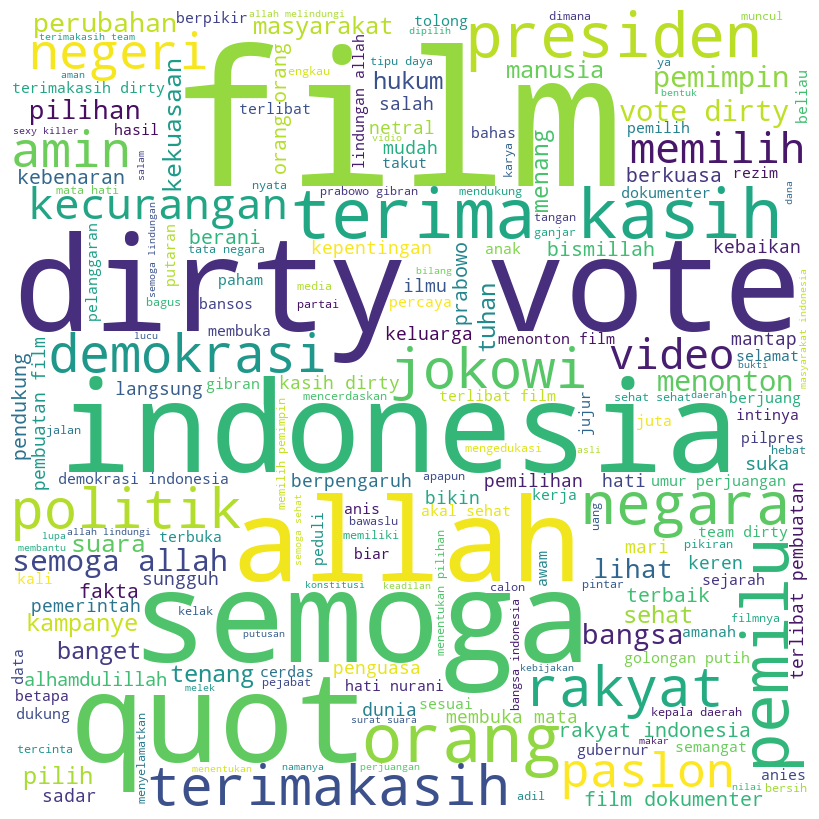

In [142]:
# Assuming the DataFrame is named 'df' and 'list_stopwords' is defined

# Get all positive sentiment
all_positive = df[df['sentiment'] == 'Positive']

# Join all positive sentiment, converting lists to strings
all_positive_text = ' '.join([' '.join(text) for text in all_positive['Text Stopwords Removal']])

# Create wordcloud object
wordcloud = WordCloud(width=800, height=800, 
                      background_color='white', 
                      stopwords=list_stopwords, 
                      min_font_size=10).generate(all_positive_text)

# Plot the WordCloud image                        
plt.figure(figsize=(8, 8), facecolor=None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad=0) 

plt.show()

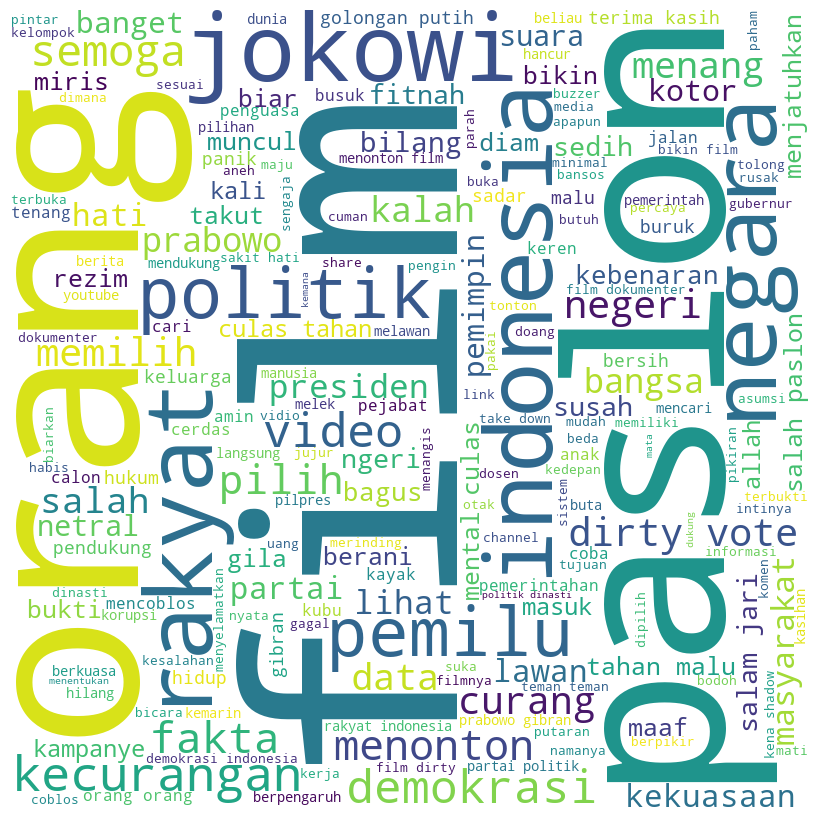

In [150]:
# Assuming the DataFrame is named 'df' and 'list_stopwords' is defined

# Get all positive sentiment
all_negative = df[df['sentiment'] == 'Negative']

# Join all positive sentiment, converting lists to strings
all_negative_text = ' '.join([' '.join(text) for text in all_negative['Text Stopwords Removal']])

# Create wordcloud object
wordcloud = WordCloud(width=800, height=800, 
                      background_color='white', 
                      stopwords=list_stopwords, 
                      min_font_size=10).generate(all_negative_text)

# Plot the WordCloud image                        
plt.figure(figsize=(8, 8), facecolor=None)  # facecolor='k' for black background
plt.imshow(wordcloud)  # interpolation='bilinear' for smooth image
plt.axis("off")  # turns off axes
plt.tight_layout(pad=0)  # adjusts the padding between the edges and the figure

plt.show()

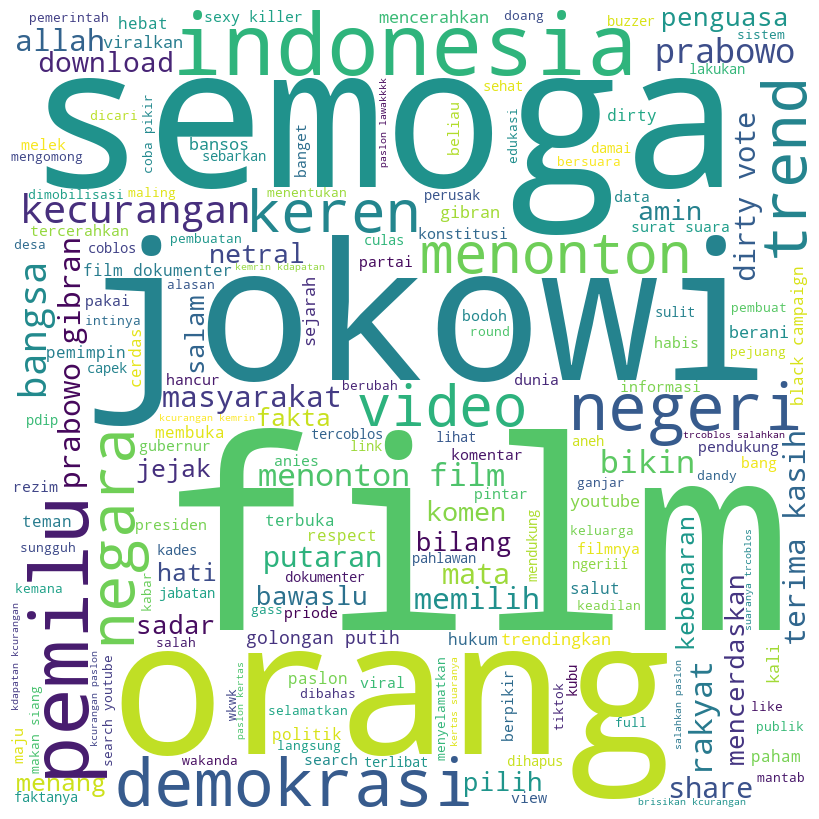

In [155]:
# Assuming the DataFrame is named 'df' and 'list_stopwords' is defined

# Get all positive sentiment
sentiment = df[df['sentiment'] == 'Neutral']

# Join all positive sentiment, converting lists to strings
sentiment = ' '.join([' '.join(text) for text in sentiment['Text Stopwords Removal']])

# Create wordcloud object
wordcloud = WordCloud(width=800, height=800, 
                      background_color='white', 
                      stopwords=list_stopwords, 
                      min_font_size=10).generate(sentiment)

# Plot the WordCloud image                        
plt.figure(figsize=(8, 8), facecolor=None)  # facecolor='k' for black background
plt.imshow(wordcloud)  # interpolation='bilinear' for smooth image
plt.axis("off")  # turns off axes
plt.tight_layout(pad=0)  # adjusts the padding between the edges and the figure

plt.show()

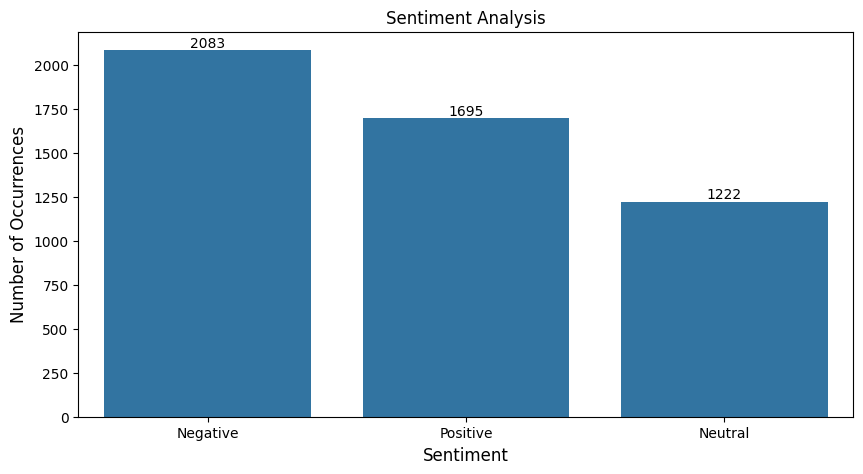

In [156]:
import seaborn as sns


# Visualize with bar plot
sentiment_count = df['sentiment'].value_counts().reset_index()
sentiment_count.columns = ['sentiment', 'count']

plt.figure(figsize=(10, 5))  # untuk mengatur ukuran plot
ax = sns.barplot(x='sentiment', y='count', data=sentiment_count)  # membuat bar plot
plt.title('Sentiment Analysis')  # judul plot
plt.ylabel('Number of Occurrences', fontsize=12)  # label y
plt.xlabel('Sentiment', fontsize=12)  # label x

# Add labels to bars
for i in ax.containers:  # loop untuk setiap bar
    ax.bar_label(i, fmt='%.0f')

plt.show()  # menampilkan plot

#### **LABELING WITH TRANSFORMERS**

In [157]:
df.columns

Index(['author', 'like_count', 'tweet', 'clean_text', 'tokenized_text',
       'Text Normalization', 'Text Stopwords Removal',
       'Sentiment Analysis Lexicon', 'polarity score', 'sentiment'],
      dtype='object')

In [161]:
from transformers import pipeline

pretrained_name = "w11wo/indonesian-roberta-base-sentiment-classifier"

nlp = pipeline(
    "sentiment-analysis",
    model=pretrained_name,
    tokenizer=pretrained_name
)

MAX_LENGTH = 512  # Maximum length for the model

def get_sentiment(text):
    # Ensure the text is within the max length
    if len(text) > MAX_LENGTH:
        text = text[:MAX_LENGTH]
    try:
        result = nlp(text)
        return result[0]['label']  # Extract the label from the result
    except Exception as e:
        print(f"Error processing text: {e}")
        return "Error"
    

# Apply the sentiment analysis to the DataFrame
df['label_transformers'] = df['tweet'].progress_apply(get_sentiment)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [165]:
df['label_transformers'].value_counts()

label_transformers
negative    2883
positive    1586
neutral      531
Name: count, dtype: int64

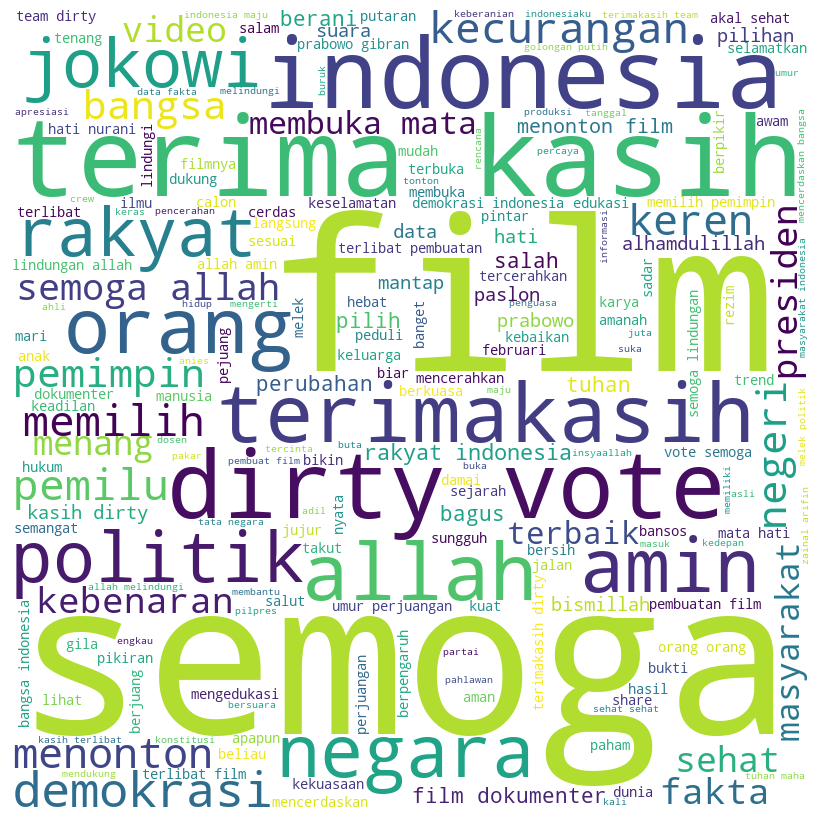

In [166]:
# Assuming the DataFrame is named 'df' and 'list_stopwords' is defined

# Get all positive sentiment
sentiment = df[df['label_transformers'] == 'positive']

# Join all positive sentiment, converting lists to strings
sentiment = ' '.join([' '.join(text) for text in sentiment['Text Stopwords Removal']])

# Create wordcloud object
wordcloud = WordCloud(width=800, height=800, 
                      background_color='white', 
                      stopwords=list_stopwords, 
                      min_font_size=10).generate(sentiment)

# Plot the WordCloud image                        
plt.figure(figsize=(8, 8), facecolor=None)  # facecolor='k' for black background
plt.imshow(wordcloud)  # interpolation='bilinear' for smooth image
plt.axis("off")  # turns off axes
plt.tight_layout(pad=0)  # adjusts the padding between the edges and the figure

plt.show()

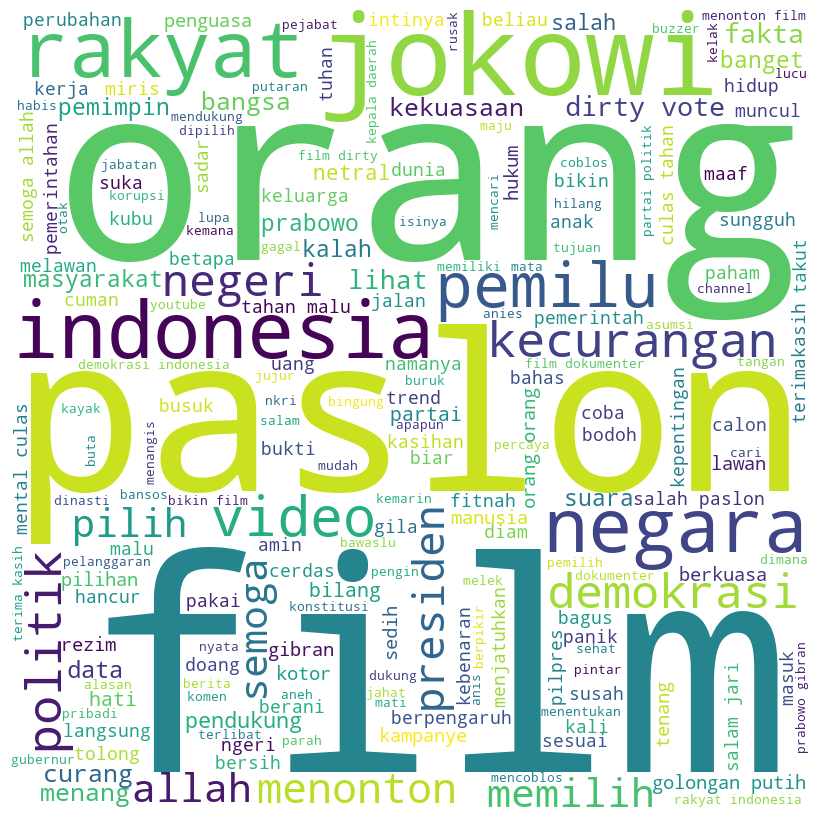

In [167]:
# Assuming the DataFrame is named 'df' and 'list_stopwords' is defined

# Get all positive sentiment
sentiment = df[df['label_transformers'] == 'negative']

# Join all positive sentiment, converting lists to strings
sentiment = ' '.join([' '.join(text) for text in sentiment['Text Stopwords Removal']])

# Create wordcloud object
wordcloud = WordCloud(width=800, height=800, 
                      background_color='white', 
                      stopwords=list_stopwords, 
                      min_font_size=10).generate(sentiment)

# Plot the WordCloud image                        
plt.figure(figsize=(8, 8), facecolor=None)  # facecolor='k' for black background
plt.imshow(wordcloud)  # interpolation='bilinear' for smooth image
plt.axis("off")  # turns off axes
plt.tight_layout(pad=0)  # adjusts the padding between the edges and the figure

plt.show()

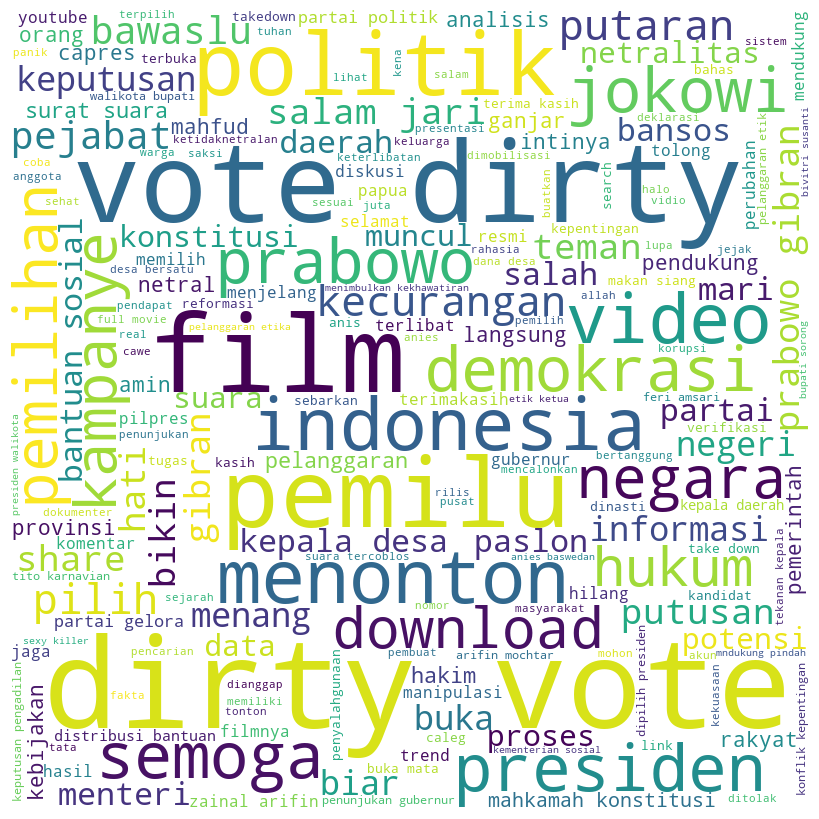

In [168]:
# Assuming the DataFrame is named 'df' and 'list_stopwords' is defined

# Get all positive sentiment
sentiment = df[df['label_transformers'] == 'neutral']

# Join all positive sentiment, converting lists to strings
sentiment = ' '.join([' '.join(text) for text in sentiment['Text Stopwords Removal']])

# Create wordcloud object
wordcloud = WordCloud(width=800, height=800, 
                      background_color='white', 
                      stopwords=list_stopwords, 
                      min_font_size=10).generate(sentiment)

# Plot the WordCloud image                        
plt.figure(figsize=(8, 8), facecolor=None)  # facecolor='k' for black background
plt.imshow(wordcloud)  # interpolation='bilinear' for smooth image
plt.axis("off")  # turns off axes
plt.tight_layout(pad=0)  # adjusts the padding between the edges and the figure

plt.show()

In [169]:
df.columns

Index(['author', 'like_count', 'tweet', 'clean_text', 'tokenized_text',
       'Text Normalization', 'Text Stopwords Removal',
       'Sentiment Analysis Lexicon', 'polarity score', 'sentiment',
       'label_transformers'],
      dtype='object')

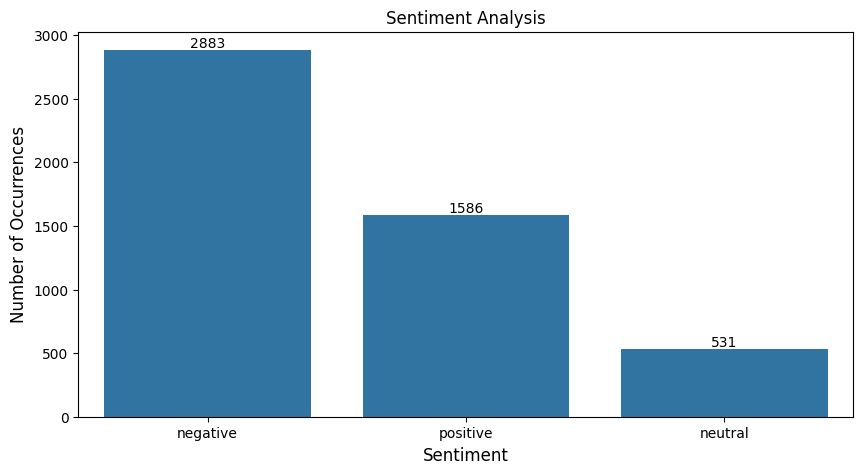

In [170]:
import seaborn as sns


# Visualize with bar plot
sentiment_count = df['label_transformers'].value_counts().reset_index()
sentiment_count.columns = ['sentiment', 'count']

plt.figure(figsize=(10, 5))  # untuk mengatur ukuran plot
ax = sns.barplot(x='sentiment', y='count', data=sentiment_count)  # membuat bar plot
plt.title('Sentiment Analysis')  # judul plot
plt.ylabel('Number of Occurrences', fontsize=12)  # label y
plt.xlabel('Sentiment', fontsize=12)  # label x

# Add labels to bars
for i in ax.containers:  # loop untuk setiap bar
    ax.bar_label(i, fmt='%.0f')

plt.show()  # menampilkan plot

In [171]:
df.loc[ df['label_transformers'] == 'neutral', :] 

,author,like_count,tweet,clean_text,tokenized_text,Text Normalization,Text Stopwords Removal,Sentiment Analysis Lexicon,polarity score,sentiment,label_transformers
11325,@DanuWidodoo,1,dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote,dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote dirty vote,"[dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, ...]","[dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, ...]","[dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, dirty, vote, ...]","(72, Positive)",72,Positive,neutral
45865,@naufalramadhan5369,0,Download dulu gaes takutnya ada apa apa,download dulu gaes takutnya,"[download, dulu, gaes, takutnya]","[download, dulu, gaes, takutnya]","[download, gaes, takutnya]","(0, Neutral)",0,Neutral,